In [ ]:
!pip install -r pip_requirements.txt

In [28]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.empath_model import *
from src.utils.statistics_utils import *
import json
import ast 

from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import chi2_contingency

Our analysis centers on the effect DVDs on the movie industry. This question was motivated by an interview with actor Matt Damon, famous for his role in [Good Will Hunting](https://www.imdb.com/title/tt0119217/?ref_=ext_shr_lnk) and [the Martian](https://www.imdb.com/title/tt3659388/?ref_=ext_shr_lnk). 

In the interview with the [New York Times](https://www.nytimes.com/2021/07/27/magazine/matt-damon.html) , he claims that with the fall of DVDs, production companies lost a sizeable portion of their revenue and must rely almost entirely on box office revenues. The consequence of this, he claims, is that movies are now simpler and more international, to ensure broad appeal and better revenues at the box office:

"You know, because the DVD market dried up [...] that severely cut into the margins that studios would rather bet big on these big titles. And with this whole international audience, the more, you know, the simpler the story the more that it can kind of play, the less language matters so that the more broad appeal that it can play around the world, and that’s why you’re seeing the movies change."

With this in mind, we will analyze the effect of DVDs on the movie industry by looking at the following aspects:
- [DVD releases over time](#DVD-releases-over-time)
- [General Overview](#General-Overview)
- [Revenue](#Revenue-overview) 
- [Budget](#Budget-overview)
- [Production company](#Production-companies)
- [Runtime](#Runtime-overview)   
- [Genre](#Genre-overview)
- [Themes](#Themes-extraction)


IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset [here](https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz)
and TMDB dataset [here (Download button)](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies)

In [4]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361971 entries, 0 to 453228
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   title                 361970 non-null  object
 1   release_date          361971 non-null  object
 2   revenue               361971 non-null  int64 
 3   runtime               361971 non-null  int64 
 4   budget                361971 non-null  int64 
 5   original_language     361971 non-null  object
 6   overview              361971 non-null  object
 7   genres                361971 non-null  object
 8   production_companies  361971 non-null  object
 9   production_countries  361971 non-null  object
 10  spoken_languages      361971 non-null  object
 11  keywords              361971 non-null  object
 12  release_year          361971 non-null  int64 
 13  dvd_era               361971 non-null  object
dtypes: int64(4), object(10)
memory usage: 41.4+ MB


There should be 361,971 entries in the dataframe. 

In [18]:
df.head()

title release_date     revenue  runtime     budget  \
0        Inception   2010-07-15   825532764      148  160000000   
1     Interstellar   2014-11-05   701729206      169  165000000   
2  The Dark Knight   2008-07-16  1004558444      152  185000000   
3           Avatar   2009-12-15  2923706026      162  237000000   
4     The Avengers   2012-04-25  1518815515      143  220000000   

  original_language                                           overview  \
0                en  Cobb, a skilled thief who commits corporate es...   
1                en  The adventures of a group of explorers who mak...   
2                en  Batman raises the stakes in his war on crime. ...   
3                en  In the 22nd century, a paraplegic Marine is di...   
4                en  When an unexpected enemy emerges and threatens...   

                                          genres  \
0           [Action, Science Fiction, Adventure]   
1            [Adventure, Drama, Science Fiction]   
2               [Drama, Action, Crime, Thriller]   
3  [Action, Adventure, Fantasy, Science Fiction]   
4           [Science Fiction, Action, Adventure]   

                                production_companies  \
0  [Legendary Pictures, Syncopy, Warner Bros. Pic...   
1  [Legendary Pictures, Syncopy, Lynda Obst Produ...   
2  [DC Comics, Legendary Pictures, Syncopy, Isobe...   
3  [Dune Entertainment, Lightstorm Entertainment,...   
4                                   [Marvel Studios]   

                         production_countries  \
0  [United Kingdom, United States of America]   
1  [United Kingdom, United States of America]   
2  [United Kingdom, United States of America]   
3  [United States of America, United Kingdom]   
4                  [United States of America]   

                       spoken_languages  \
0  [English, French, Japanese, Swahili]   
1                             [English]   
2                   [English, Mandarin]   
3                    [English, Spanish]   
4             [English, Hindi, Russian]   

                                            keywords  release_year dvd_era  
0  [rescue, mission, dream, airplane, paris, fran...          2010  during  
1  [rescue, future, spacecraft, race against time...          2014    post  
2  [joker, sadism, chaos, secret identity, crime ...          2008  during  
3  [future, society, culture clash, space travel,...          2009  during  
4  [new york city, superhero, shield, based on co...          2012  during

We see that not all movies have revenue, runtime, or budget information as they are set to zero. However, we keep these movies in our dataset as they might be associated other relevant information. For any analysis pertaining to these features, we ensure instead to exclude any movies for which their value is 0. 

To start our analysis we looked at DVD releases over time to properly define our eras. 


# DVD releases over time

In [5]:
df_dvd_releases = load_raw_data('data/processed/dvd_releases.csv')
df_dvd_releases['dvd_release_date'] = pd.to_datetime(df_dvd_releases['dvd_release_date'])
df_grouped = df_dvd_releases.resample('ME', on='dvd_release_date').size()

Loading data from data/processed/dvd_releases.csv...


In [6]:
# Calculate our eras using our data
peak_date = df_grouped.idxmax()
peak_value = df_grouped.max()
mean_releases = df_grouped.mean()
std_releases = df_grouped.std()
threshold_low = mean_releases - std_releases
threshold_high = mean_releases + std_releases

pre_dvd_end = df_grouped[df_grouped > threshold_high].index[0]  # First time crosses upper threshold
post_dvd_start = df_grouped[df_grouped > threshold_high].index[-1]  # Last time crosses upper threshold
print(f"Pre-DVD Era: Before {pre_dvd_end.strftime('%Y')}")
print(f"DVD Era: {pre_dvd_end.strftime('%Y')} to {post_dvd_start.strftime('%Y')}")
print(f"Post-DVD Era: After {post_dvd_start.strftime('%Y')}")

Pre-DVD Era: Before 1997
DVD Era: 1997 to 2013
Post-DVD Era: After 2013


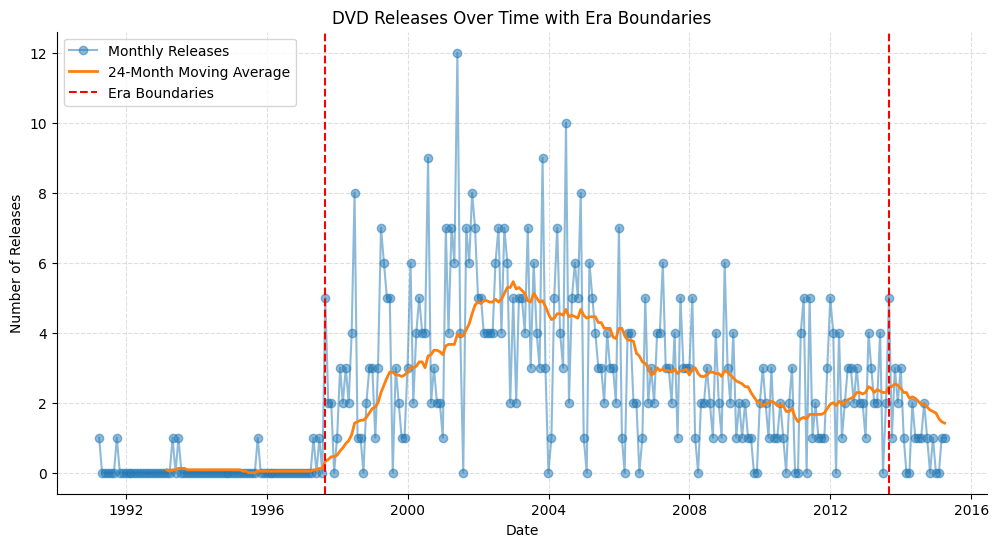

In [7]:
# This plot shows the trend in monthly DVD releases over time, 
# highlighting key era boundaries and smoothing fluctuations with a 24-month moving average.

moving_avg = df_grouped.rolling(window=24).mean() 
plt.figure(figsize=(12, 6))

plt.plot(df_grouped.index, df_grouped.values, marker='o', alpha=0.5, label='Monthly Releases')
plt.plot(moving_avg.index, moving_avg.values, linewidth=2, label='24-Month Moving Average')

# Draw the era boundaries
plt.axvline(x=pre_dvd_end, color='r', linestyle='--', label='Era Boundaries')
plt.axvline(x=post_dvd_start, color='r', linestyle='--')

style_plot('DVD Releases Over Time with Era Boundaries', 'Date', 'Number of Releases', True)

# Revenue overview
We first obtain an overview of movie revenues, considering all movies together.

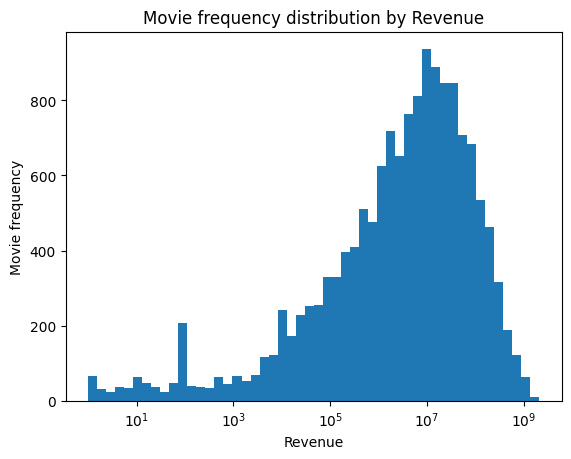

In [8]:
# Frequency distribution per budget, with budget in logscale 
plot_loghist(df[df['revenue'] > 0]['revenue'], 50, xlabel='Revenue', ylabel='Movie frequency')

We then analyse revenue by DVD eras.

In [9]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era           pre        during          post
count    3.079000e+03  6.112000e+03  5.863000e+03
mean     3.269406e+07  5.051136e+07  4.830182e+07
std      7.215145e+07  1.193980e+08  1.515094e+08
min      1.000000e+00  1.000000e+00  1.000000e+00
25%      1.220048e+06  5.167322e+05  1.000000e+05
50%      8.894289e+06  6.632393e+06  2.228115e+06
75%      2.917746e+07  4.188264e+07  2.020445e+07
max      9.201000e+08  1.518816e+09  2.068224e+09

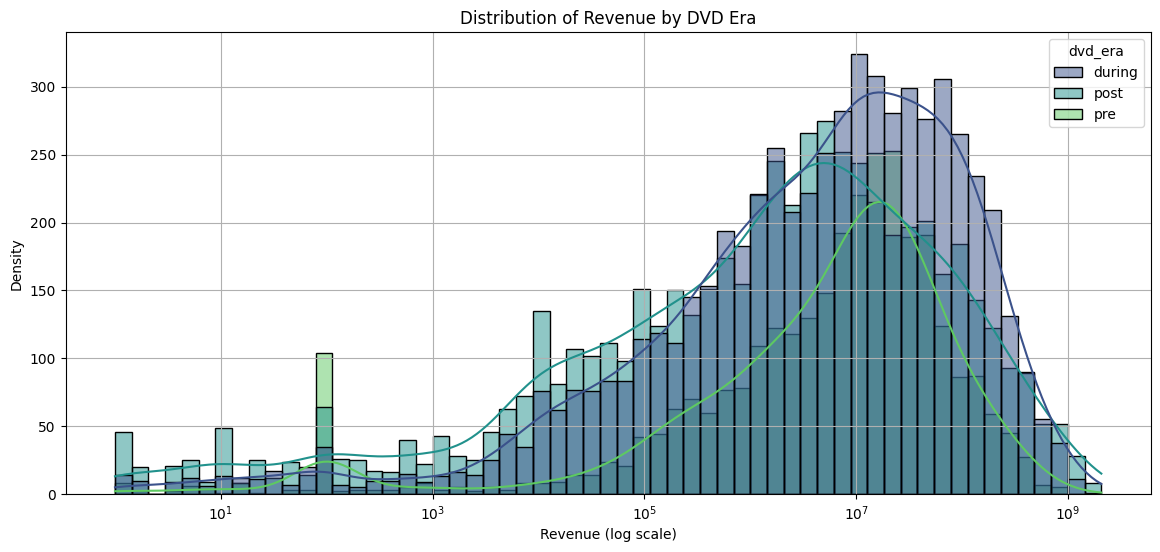

In [10]:
# Revenue per era
plot_revenue_per_era(df)

# Budget overview

## Exploration

We then consider budget distributions.

In [11]:
# This code calculates and displays summary statistics for movie budgets across different DVD eras.

df_filtered = df[(df['budget'] > 0)]

print('Summary statistics of budget for each DVD era:')
df_filtered.groupby('dvd_era')['budget'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of budget for each DVD era:


dvd_era           pre        during          post
count    3.048000e+03  9.461000e+03  1.162500e+04
mean     1.099374e+07  1.416679e+07  8.876990e+06
std      1.488392e+07  2.873422e+07  2.925404e+07
min      1.000000e+00  1.000000e+00  1.000000e+00
25%      6.000000e+05  2.000000e+05  3.000000e+03
50%      5.475000e+06  2.400000e+06  1.400000e+05
75%      1.500000e+07  1.400000e+07  3.500000e+06
max      1.750000e+08  3.790000e+08  8.880000e+08

We can see that most budget statistics (quantiles, median and mean) are lower in the post-DVD era, but the maximum budget is higher. 

We examine the budget trends in more details using plots. 

In [12]:
# Plot mean budget across time, accounting for inflation
plot_mean_budget_inflation(df)

The following plots allow to better observe the difference in budget distribution over the years !

In [13]:
plot_movies_budget_slider(df_filtered, mode='budget')      # Budget mode (default)
plot_movies_budget_slider(df_filtered, mode='relative')    # Relative mode
plot_movies_budget_slider(df_filtered, mode='percentage')  # Percentage mode

We can use histograms to compare film budgets before, during and after the DVD era. We use a log-scale to represent movies with both small and high budgets on the same graph. This leads to the results of pre vs. post DVD era to be unreadable. 


We can nevertheless interpret the results for adjacent eras :
- Pre vs. during: before DVDs, only high budgets films were produced, with a mono-modal distribution, around 10^7 dollars budget. During the DVD era, the distribution widened, with smaller budget films being produced.
- During vs. post: after the DVD era, we see the distribution becoming more bimodal with another density maximum around 10^4 dollars.

Interpreting this is tricky : maybe more movies can become available in streaming services, pushing for smaller-budget productions.

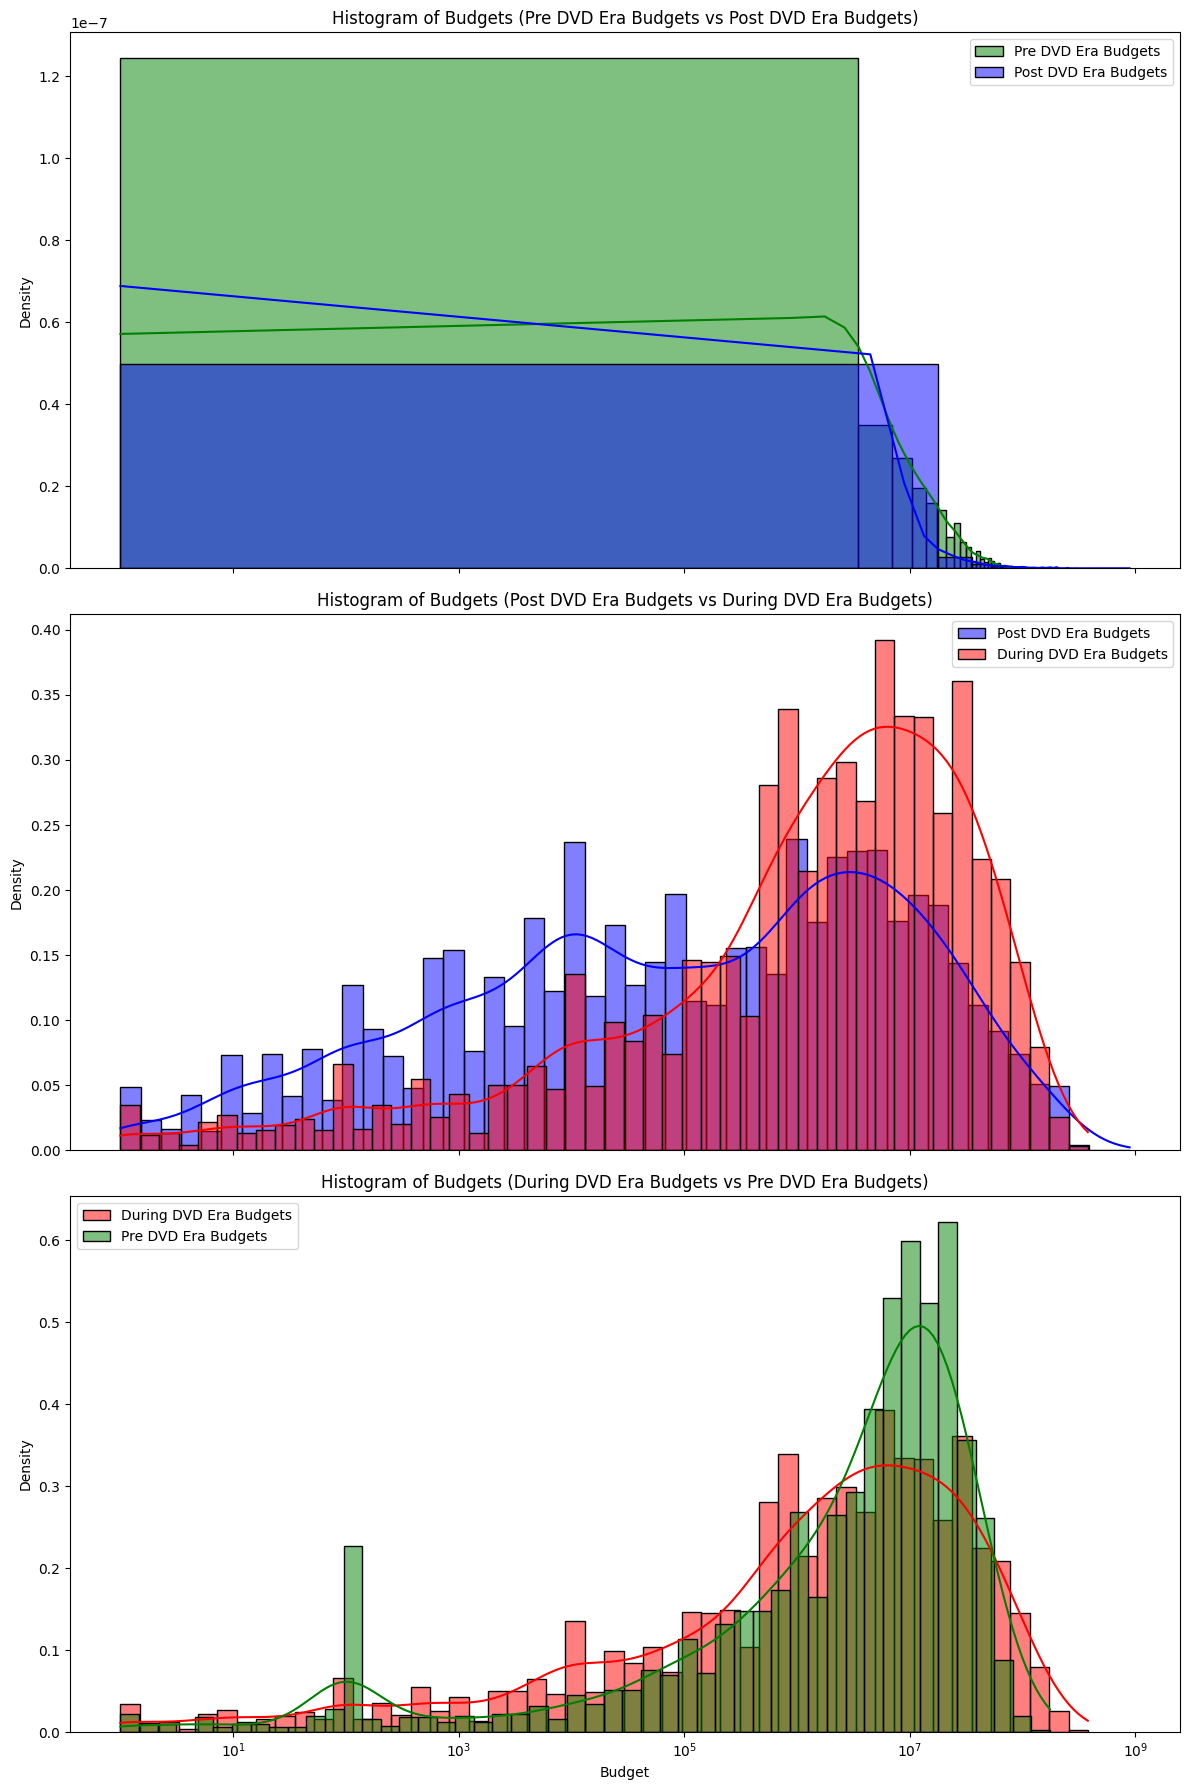

In [14]:
# This code compares film budgets across DVD eras using log-scale histograms to highlight distribution changes and trends between adjacent eras.
# The comparison examines budget distributions before, during, and after the DVD era.


# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

We categorize the movies in different types according to their budgets (compared to the mean) :
- Independent movies: less than 1/10th of the mean budget.
- Small productions: Between 1/10th and 1 of the mean budget.
- Big productions: Between 1 and 5 times the mean budget.
- Super productions More than 5 times the mean budget.

We then plot the proportion of those movies (over the total) using a 3 years rolling average.

The most interesting finding is that the DVD era seems to correspond to a loss of interest for really expensive movies. This can be explained by the fact that :
- Before DVDs, going to the cinema was exceptional, but also the only way to consume movies. So only big franchises with high production budgets could really make a lot of profit.
- After DVDs, the streaming platforms want to differentiate from each other by giving access to exceptional movies, that are really costly.

In [15]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

c:\Users\nicol\OneDrive - CentraleSupelec\Bureau\Cours EPFL\ADA\Project\ada-2024-project-databand\src\utils\data_utils.py:131: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
# This code calculates the mean budget per release year, categorizes movies by production type based on budget, 
# and organizes categorical columns for DVD era and production type.

mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget = ('budget', 'mean'))
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))
df['dvd_era'] = pd.Categorical(df['dvd_era'], categories=['pre', 'during', 'post'], ordered=True)
df['prod_type'] = pd.Categorical(df['prod_type'], categories=['Independent', 'Small', 'Big', 'Super'], ordered=True)

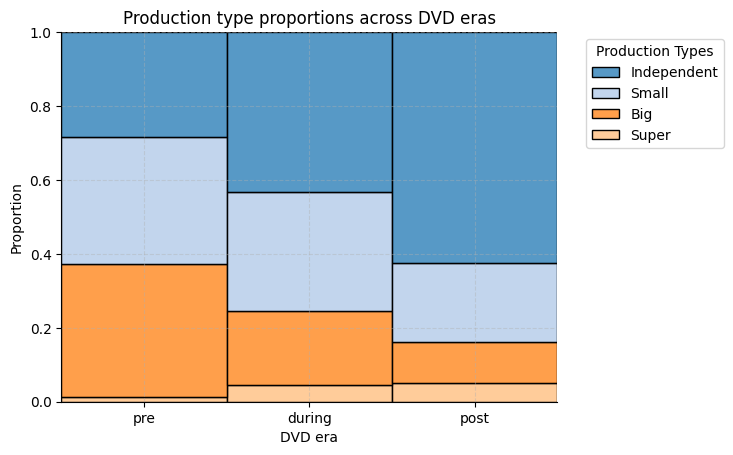

In [17]:
# This plot visualizes the proportion of production types (Independent, Small, Big, Super) across different DVD eras.

fig = sns.histplot(data = df[df.budget > 0], x='dvd_era', hue='prod_type', 
             multiple='fill', palette='tab20', )
sns.move_legend(fig, loc='upper right', bbox_to_anchor=(1.35,1),title='Production Types')
style_plot('Production type proportions across DVD eras', 'DVD era', 'Proportion')

## Statistical tests

In [18]:
# Filter out rows with budget <= 0
df_filtered_budget = df[df['budget'] > 0]

# Linear regression model
X = sm.add_constant(df_filtered_budget['release_year'])
y = df_filtered_budget['budget']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 budget   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     77.76
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           1.24e-18
Time:                        21:25:01   Log-Likelihood:            -4.4783e+05
No. Observations:               24134   AIC:                         8.957e+05
Df Residuals:                   24132   BIC:                         8.957e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.048e+08   3.33e+07      9.155   

We observe a really bad $R^2$ that shows that the regression is not satisfying. Given the general form of the plot, this is not a surprise.

In [19]:
# ANOVA test
anova_model = ols('budget ~ C(release_year)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                       sum_sq        df          F         PR(>F)
C(release_year)  3.802337e+16      47.0  13.761637  2.684742e-106
Residual         2.137720e+19  363637.0        NaN            NaN


Significance of release_year: The very low p-value suggests that the release year has a significant effect on the dependent variable. In other words, the differences in means across the years are unlikely to be due to random chance.

F-statistic: The F-statistic of 13.72 supports this conclusion, showing that the between-group variance (due to release_year) is large relative to the within-group variance (residuals).

Residuals: While release_year is significant, the residual sum of squares is much larger than the explained sum of squares, suggesting that there is still a large amount of variability in the data that is unexplained by release_year.

In [20]:
# Create a contingency table for chi-square test
contingency_table = pd.crosstab(df_filtered['dvd_era'], df_filtered['budget'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square test statistic: 9184.06373236485
P-value: 3.9153454204873014e-105
Degrees of freedom: 6400


This indicates that there is extremely strong evidence against the null hypothesis (no association between budget and dvd era), and we can conclude that there is a statistically significant association between dvd_era and budget.

# Production Companies

We then take a look at production companies

In [21]:
# Get number of production companies for each movie 
num_production_companies = df['production_companies'].str.len()

# Get most common number of production companies with their counts 
company_counts = num_production_companies.value_counts().sort_index()


production_companies
0    187856
1    106093
2     37135
3     17121
4      7072
Name: count, dtype: int64

In [22]:
print(f"Movies with single production company: {company_counts.get(1, 0):,} ({company_counts.get(1, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with multiple production companies: {company_counts[company_counts.index > 1].sum():,} ({company_counts[company_counts.index > 1].sum()/company_counts.sum()*100:.1f}%)")

Movies with single production company: 106,093 (29.2%)
Movies with multiple production companies: 69,736 (19.2%)



Considering movies that have >=1 production company, we plot the frequency distribution. 

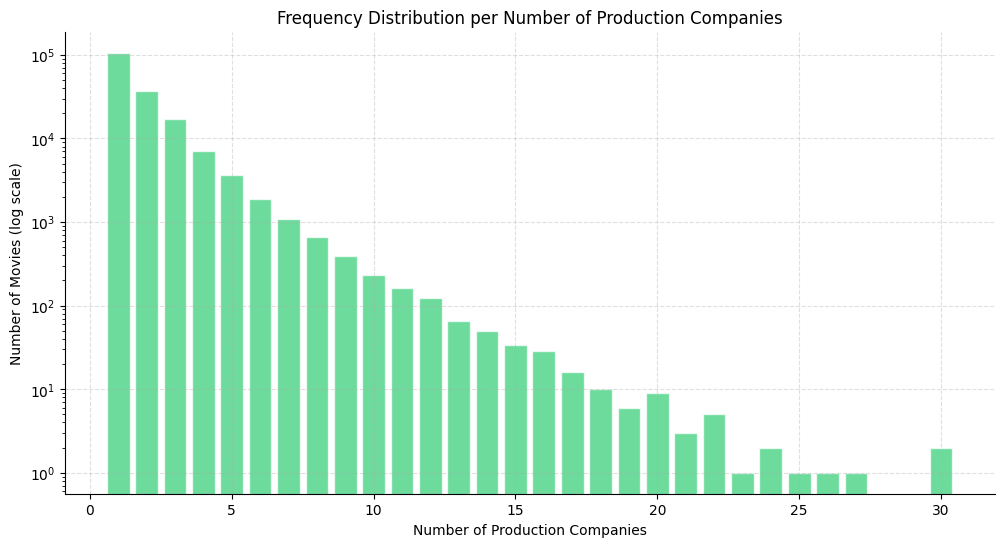

In [23]:
# This plot visualizes the frequency distribution of movies by the number of production companies involved, 
# using a log scale for clarity.

company_counts = company_counts[company_counts.index > 0]
plt.figure(figsize=(12, 6))
plt.bar(company_counts.index, company_counts.values, color='#2ecc71', alpha=0.7, edgecolor='white')

plt.yscale('log')
style_plot('Frequency Distribution per Number of Production Companies', 'Number of Production Companies', 'Number of Movies (log scale)', False)

 Interestingly, there are a high number of movies with more than one production company. Production companies have the resources (creative or financial) to make the movies possible. It would be interesting to see how the number of production companies per movie has evolved over time. 

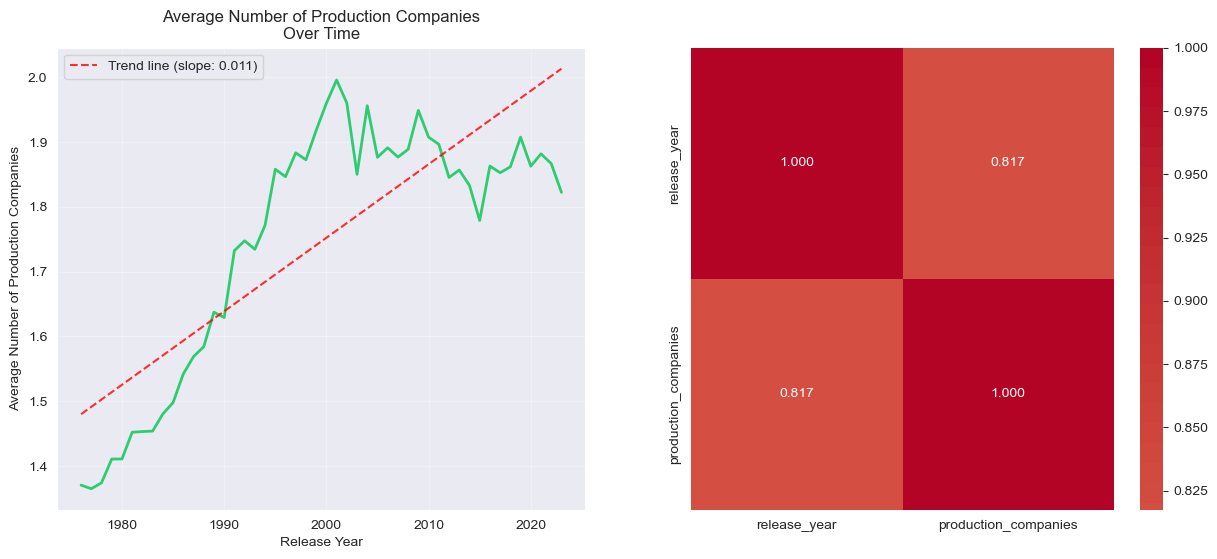

In [9]:
# This code calculates and visualizes the mean number of production companies per year, including a trend line and correlation analysis.

# Get mean number of production companies per year
yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())

plot_avg_num_prod_companies(yearly_avg_companies)

From this initial analysis, there is a strong correlation between the number of production companies per movie and the release year. 

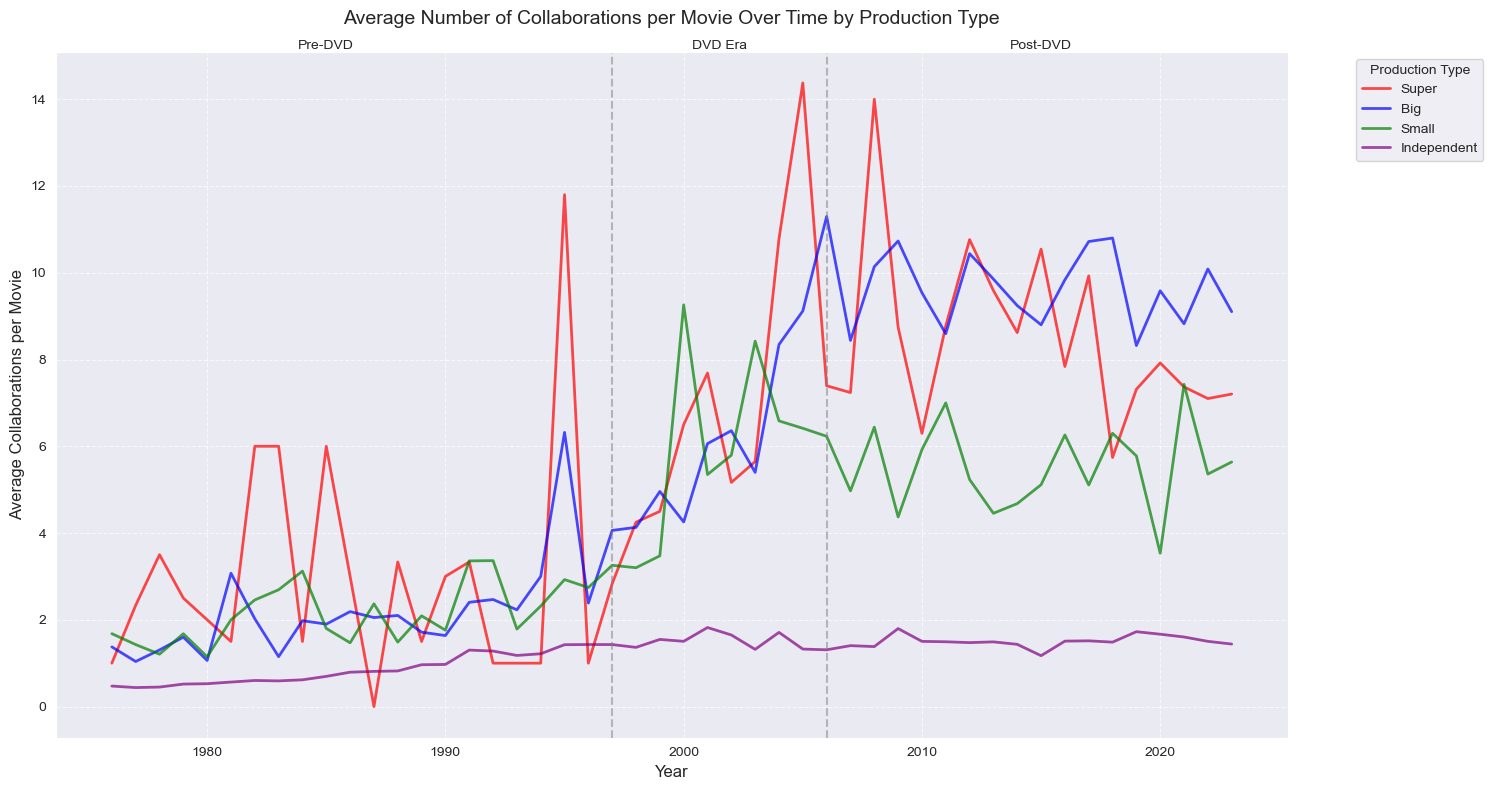

In [11]:
# Plotting the average number of collaborations per movie over time by production type
plot_num_companies_per_prod_type(df)

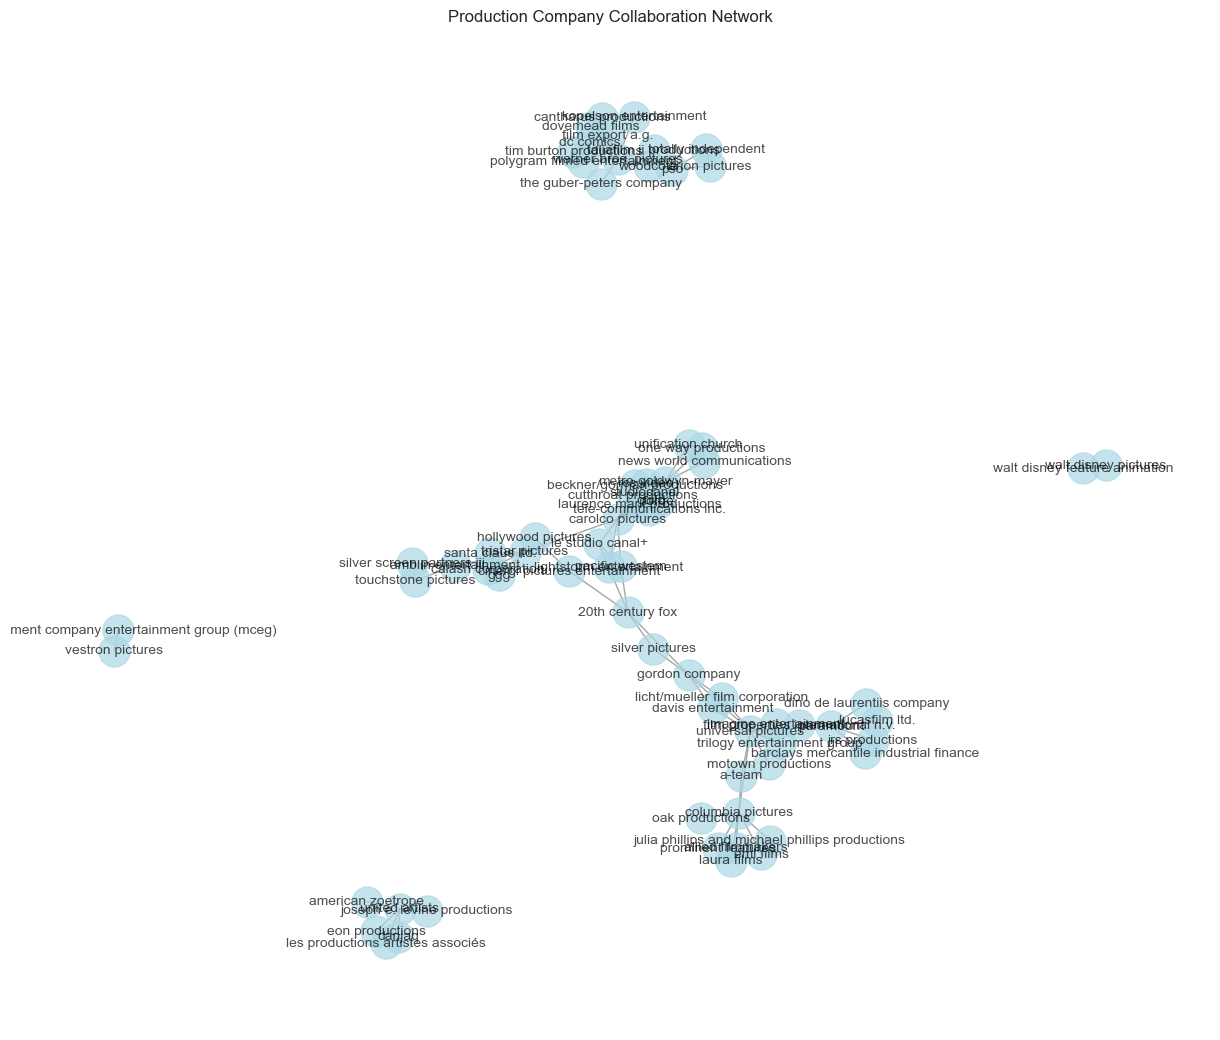

In [22]:
df_graph = df[df['production_companies'].str.len() > 0]

# Filtering the data to get only movies that belong to the 'Super' production type and were released in the 'pre' DVD era
before_DVD_era_super = df_graph[(df_graph['dvd_era'] == 'pre') & (df_graph['prod_type'] == 'Super')]

# Function to visualize the collaboration network for this subset
plot_collaborations(before_DVD_era_super)

Statistical analyses

In [53]:
production_types = ['Super', 'Big', 'Small', 'Independent']
analysis_df = get_prod_companies_analysis_df(df_graph, production_types)

In [45]:
print("Linear Regression Analysis:")
print(lin_reg_prod_companies(production_types, analysis_df))

Linear Regression Analysis:
    Production  R-Squared       p_value  Coefficient (slope)
0        Super   0.427064  6.359316e-07             0.170162
1          Big   0.839894  6.393431e-20             0.237238
2        Small   0.569877  5.706316e-10             0.113327
3  Independent   0.710108  5.893297e-14             0.024976


In [56]:
print("\nSpearman Correlation Analysis:")
print(spearman_prod_companies(production_types, analysis_df))


Spearman Correlation Analysis:
    Production  Correlation coefficient       p-value
0        Super                 0.689466  8.347368e-08
1          Big                 0.901650  2.316950e-18
2        Small                 0.797330  1.186138e-11
3  Independent                 0.820560  9.433065e-13


# Genre overview


Analyzing the distribution of movie genres across DVD eras as a first step to understand overall trends, and identify any possible significance, before considering how these trends may vary across different production types.

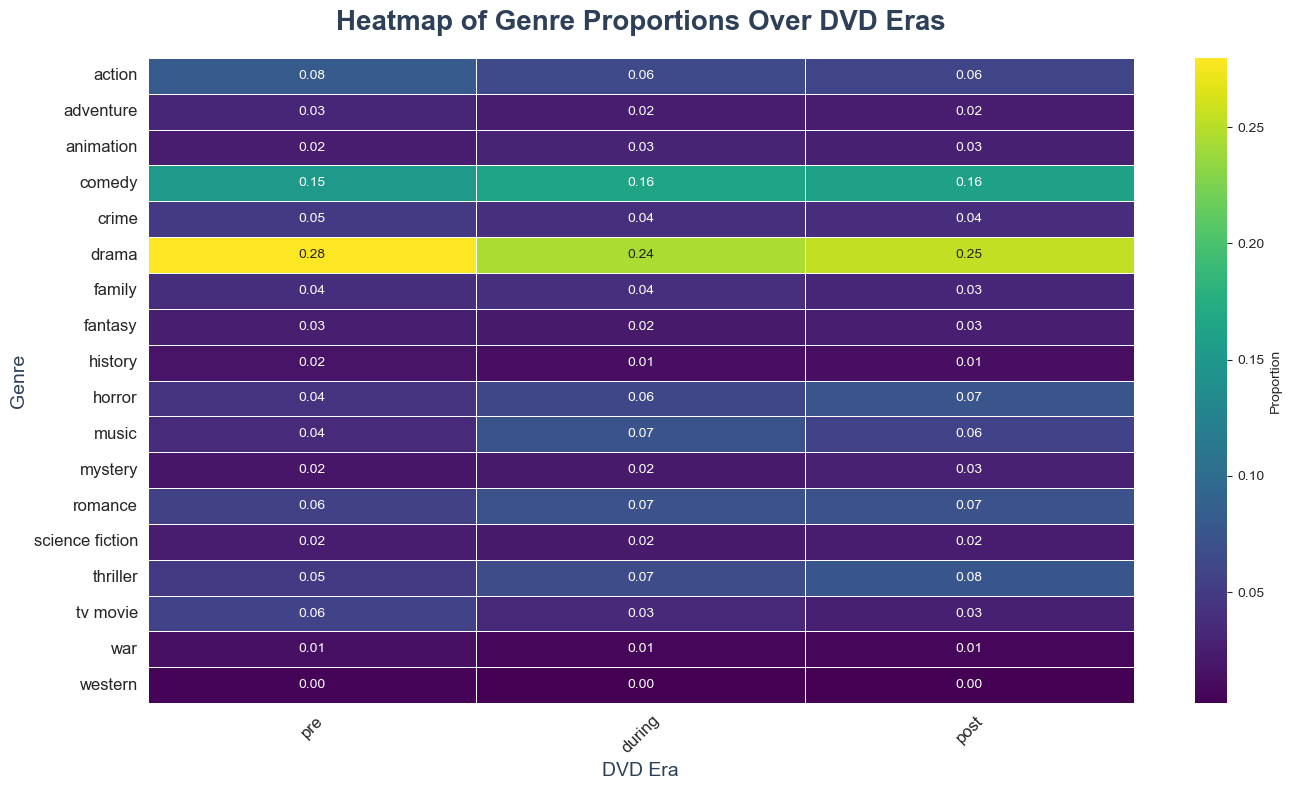

In [22]:
# select rows with at least one genre entry
df_genres = df[df.genres.apply(lambda x: len(x) > 0)].copy()

# explode genres list
df_genres = df_genres.explode('genres')

genre_proportions = get_proportions(df_genres, base_vars=['dvd_era'], target_var='genres').pivot_table(columns='dvd_era', index='genres', values='prop', observed=False)
create_genre_proportions_heatmap(genre_proportions)


In [23]:
chi2_stat, p_value, dof, expected = chi2_contingency(genre_proportions)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")


expected_table = pd.DataFrame(expected, index=genre_proportions.index, columns=genre_proportions.columns)
print("\nExpected Frequencies:")
expected_table


Chi-Square Test Results:
Chi-Square Statistic: 0.06371903130112785
P-Value: 1.0
Degrees of Freedom: 34

Expected Frequencies:


dvd_era               pre    during      post
genres                                       
action           0.068372  0.068372  0.068372
adventure        0.027010  0.027010  0.027010
animation        0.027036  0.027036  0.027036
comedy           0.158630  0.158630  0.158630
crime            0.042232  0.042232  0.042232
drama            0.259274  0.259274  0.259274
family           0.036783  0.036783  0.036783
fantasy          0.024195  0.024195  0.024195
history          0.013817  0.013817  0.013817
horror           0.059307  0.059307  0.059307
music            0.055286  0.055286  0.055286
mystery          0.022483  0.022483  0.022483
romance          0.067241  0.067241  0.067241
science fiction  0.022963  0.022963  0.022963
thriller         0.063912  0.063912  0.063912
tv movie         0.038817  0.038817  0.038817
war              0.009452  0.009452  0.009452
western          0.003191  0.003191  0.003191

These results indicate that there is no statistically significant difference in the distribution of genres across the DVD eras when using the chi-square test. A p-value of 1.0 suggests that any changes observed in genre distribution are likely due to chance rather than a significant shift over time. This outcome implies that the proportions of genres did not change significantly across the eras examined (pre, during, and post).

In [24]:
# since we look at production types, only consider movies that have a budget > 0
df_genres = df_genres[df_genres.budget > 0]

In [25]:
# get proportion of movies per genre, for each prod_type-dvd_era pair
genre_proportions = get_proportions(df_genres, base_vars=['prod_type', 'dvd_era'], target_var='genres')

We first analyse the global genre trends between different production types to examine which genres are most popular. 

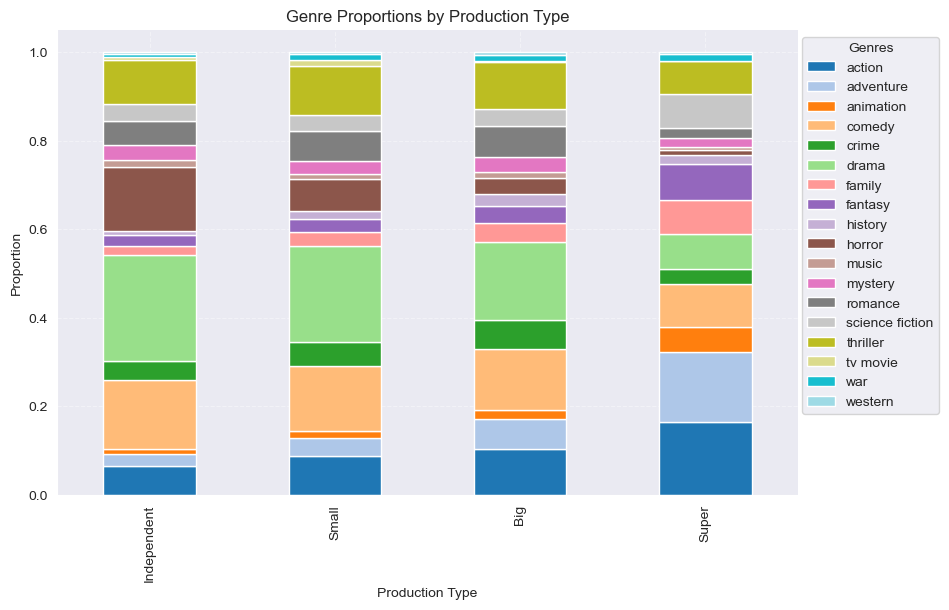

In [26]:
plot_genre_prop_by_prod_type(genre_proportions)

We can observe that for across production types, popular genres include 'drama', 'comedy', 'action', and 'adventure', with the first two being most popular for Independent and Small production types and the latter two being most popular for Super productions. 

To gain more insights, we examine whether, for each production types, some genres become more or less popular over time i.e., across DVD eras.  

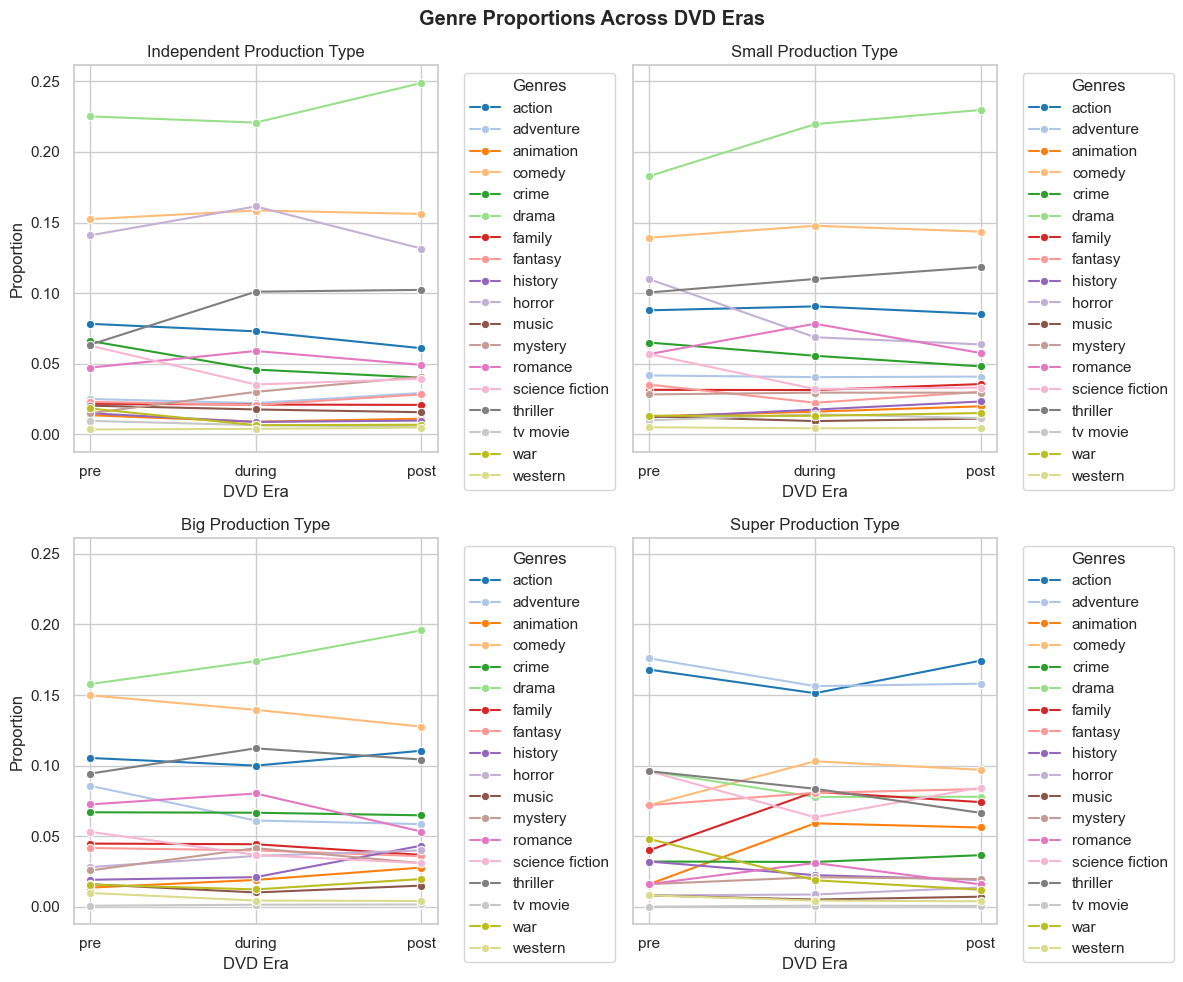

In [27]:
# This function visualizes how the proportions of different movie genres change over time 
# (across different DVD eras) for different production types.

plot_genre_trends_by_prod_type(genre_proportions)

Overall, we do not see any significant changes in genre popularity across DVD eras within specific production types. However, we can still observe that drama movies become slightly more popular (between 2-5% increase) over time for Independent, Small, and Big production types.  

Our next approach is identify the top 10% of high-revenue films by genre and era,and their contributions adjusted for inflation and seeing if there is any major shifts.

In [36]:
genre_mean_revenues_pivot = get_top_genre_contributions(df)
genre_mean_revenues_pivot 

dvd_era        action     adventure     animation        comedy  \
0     pre  3.069773e+07  5.065436e+07  1.204522e+07  1.963017e+07   
1  during  7.517876e+07  1.356909e+08  7.788598e+07  3.680222e+07   
2    post  8.264472e+07  1.418357e+08  6.135027e+07  2.590911e+07   

          crime         drama        family       fantasy       history  \
0  2.175812e+07  1.233133e+07  2.693539e+07  2.893733e+07  1.523257e+07   
1  3.853112e+07  2.287540e+07  7.682841e+07  1.137838e+08  3.601309e+07   
2  3.134471e+07  1.467650e+07  7.418099e+07  8.671115e+07  3.573094e+07   

         horror         music       mystery       romance  science fiction  \
0  9.949174e+06  7.982715e+06  2.193777e+07  2.261218e+07     4.425735e+07   
1  1.839839e+07  8.088193e+06  4.522932e+07  3.483250e+07     9.476295e+07   
2  1.617171e+07  7.743546e+06  2.762315e+07  1.740155e+07     1.253228e+08   

       thriller       tv movie           war       western  
0  3.371467e+07  122937.049708  2.270510e+07  3.572315e+07  
1  4.719471e+07  904078.989848  4.395727e+07  4.369312e+07  
2  3.159055e+07  269661.586538  4.808403e+07  2.610056e+07

In [37]:
# Adjust mean revenues for each genre to account for inflation over the years

adjustment_factors = {
    'during_to_pre': 0.91,  
    'post_to_pre': 0.73     
}


for genre in genre_mean_revenues_pivot.columns[1:]:  
    genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'during', genre] *= adjustment_factors['during_to_pre']
    genre_mean_revenues_pivot.loc[genre_mean_revenues_pivot['dvd_era'] == 'post', genre] *= adjustment_factors['post_to_pre']

genre_mean_revenues_pivot.head()

dvd_era        action     adventure     animation        comedy  \
0     pre  3.069773e+07  5.065436e+07  1.204522e+07  1.963017e+07   
1  during  6.841267e+07  1.234787e+08  7.087624e+07  3.349002e+07   
2    post  6.033064e+07  1.035401e+08  4.478569e+07  1.891365e+07   

          crime         drama        family       fantasy       history  \
0  2.175812e+07  1.233133e+07  2.693539e+07  2.893733e+07  1.523257e+07   
1  3.506332e+07  2.081661e+07  6.991385e+07  1.035433e+08  3.277191e+07   
2  2.288163e+07  1.071385e+07  5.415212e+07  6.329914e+07  2.608358e+07   

         horror         music       mystery       romance  science fiction  \
0  9.949174e+06  7.982715e+06  2.193777e+07  2.261218e+07     4.425735e+07   
1  1.674253e+07  7.360256e+06  4.115868e+07  3.169757e+07     8.623428e+07   
2  1.180535e+07  5.652789e+06  2.016490e+07  1.270313e+07     9.148563e+07   

       thriller       tv movie           war       western  
0  3.371467e+07  122937.049708  2.270510e+07  3.572315e+07  
1  4.294719e+07  822711.880761  4.000111e+07  3.976074e+07  
2  2.306110e+07  196852.958173  3.510134e+07  1.905341e+07

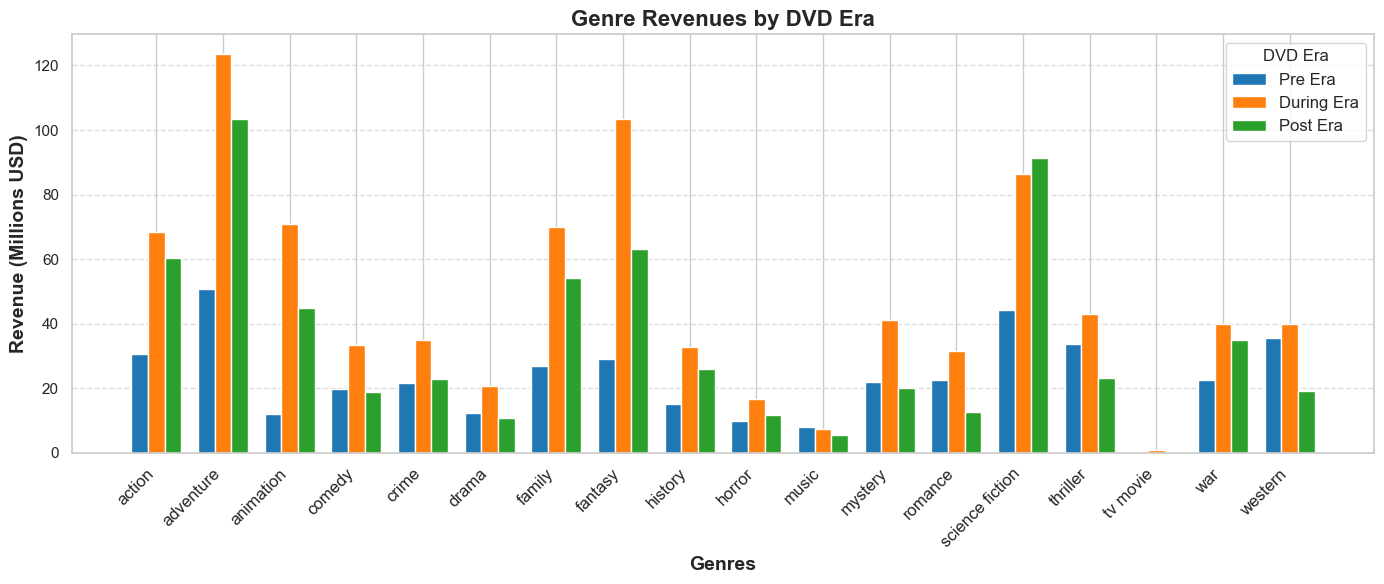

In [38]:
# Plot that shows the contribution of each genre's revenue across different DVD eras 
create_genre_contributions_plot(genre_mean_revenues_pivot)

The analysis of high-revenue movie distribution by genre and DVD era reveals shifts in genre popularity and revenue contributions across different periods. By calculating mean revenues adjusted for inflation, we identified how each genre's share of high-revenue films either increased or decreased from the pre-DVD era to the post-DVD era.

# Theme extraction

We want to analyze whether main topics within genres change between different DVD eras. For this, we focus on the most popular genres highlighted above i.e., 'drama', 'comedy', 'action', 'adventure', and use the Empath library to extract the most common themes. We analyze the trends of the top 10 most common topics for each DVD era. 

In [58]:
df_genres['clean_overview'] = df_genres.overview.apply(clean_text)
empathModel = EmpathModel()
selected_genres = ['drama', 'comedy', 'action', 'adventure']
prod_types = ['Independent', 'Small', 'Big', 'Super']

In [12]:
results = empathModel.get_features_genres_prods(df_genres, selected_genres, prod_types)
results.head()

Extracting features for Independent drama movies
Extracting features for Small drama movies
Extracting features for Big drama movies
Extracting features for Super drama movies
Extracting features for Independent comedy movies
Extracting features for Small comedy movies
Extracting features for Big comedy movies
Extracting features for Super comedy movies
Extracting features for Independent action movies
Extracting features for Small action movies
Extracting features for Big action movies
Extracting features for Super action movies
Extracting features for Independent adventure movies
Extracting features for Small adventure movies
Extracting features for Big adventure movies
Extracting features for Super adventure movies


prod_type  genre              word     era    factor
0  Independent  drama  negative_emotion  during  0.017681
1  Independent  drama           wedding  during  0.019733
2  Independent  drama          children  during  0.036377
3  Independent  drama             youth  during  0.015313
4  Independent  drama             death  during  0.024650

In [59]:
#results = pd.read_csv('data/website_data/TMDB/topics_per_genre_prod.csv')
#results.era = pd.Categorical(results.era, categories=['pre', 'during', 'post'], ordered=True)

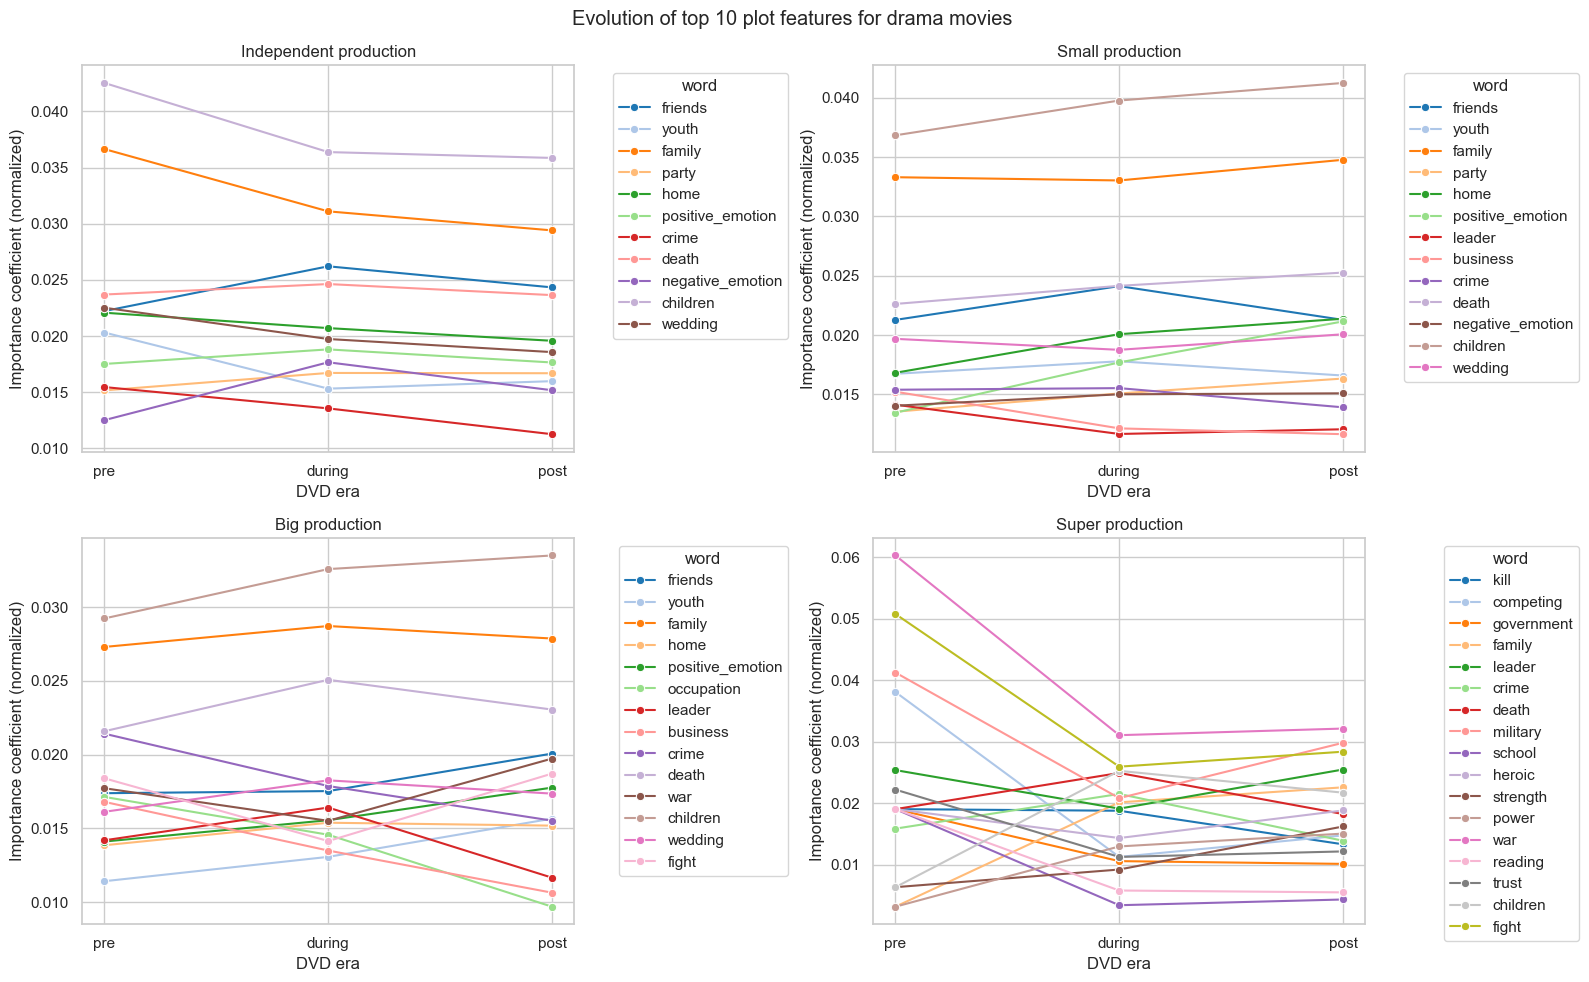

In [31]:
# Plot all features for the 'drama' genre to visualize common themes across DVD eras.

empathModel = EmpathModel()
empathModel.plot_all_features(results, 'drama')

For drama movies, we observe that the most common themes for Independent, Small and Big productions are family and children. For Small and Big productions, these themes' importance stay relatively stable, if not increase slightly, across DVD eras, while they become less prominent for Independent movies across time. In comparison, Super production drama movies' show a clear dominance of war, fight, and military themes in the pre-DVD era. Their importance becomes less superior after the onset of DVDs, but they still remain amongst the most popular themes.  

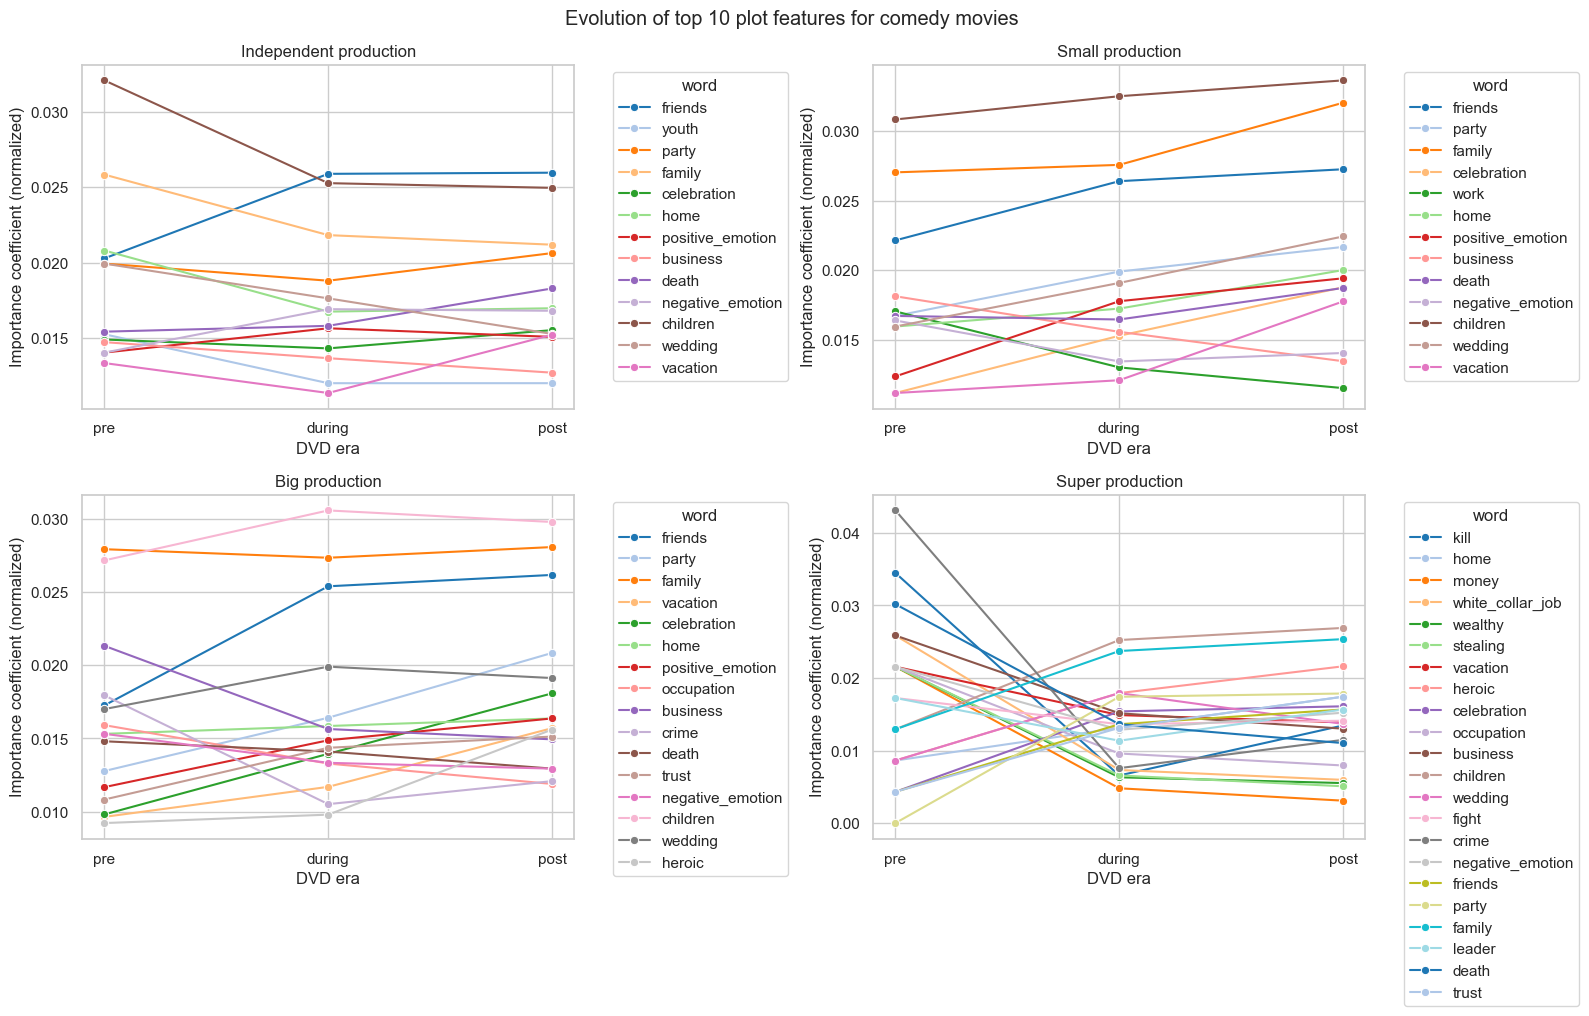

In [32]:
# Plot all features for the 'comedy' genre to visualize common themes across DVD eras.

empathModel.plot_all_features(results, 'comedy')

For the comedy genre, Independent production movies in the pre-DVD era have an important family and children component, which become less significant to make way for a friends component. Small production movies show a steady importance of friends, children, and family. Big production movies display a similar trend, though friends become more common during the DVDs era. Lastly, for Super productions, we observe an interesting pattern where common themes from the pre-DVD era, such as crime and kill, become less important at the onset of DVDs, to be replaced by family and children like in other productions. 

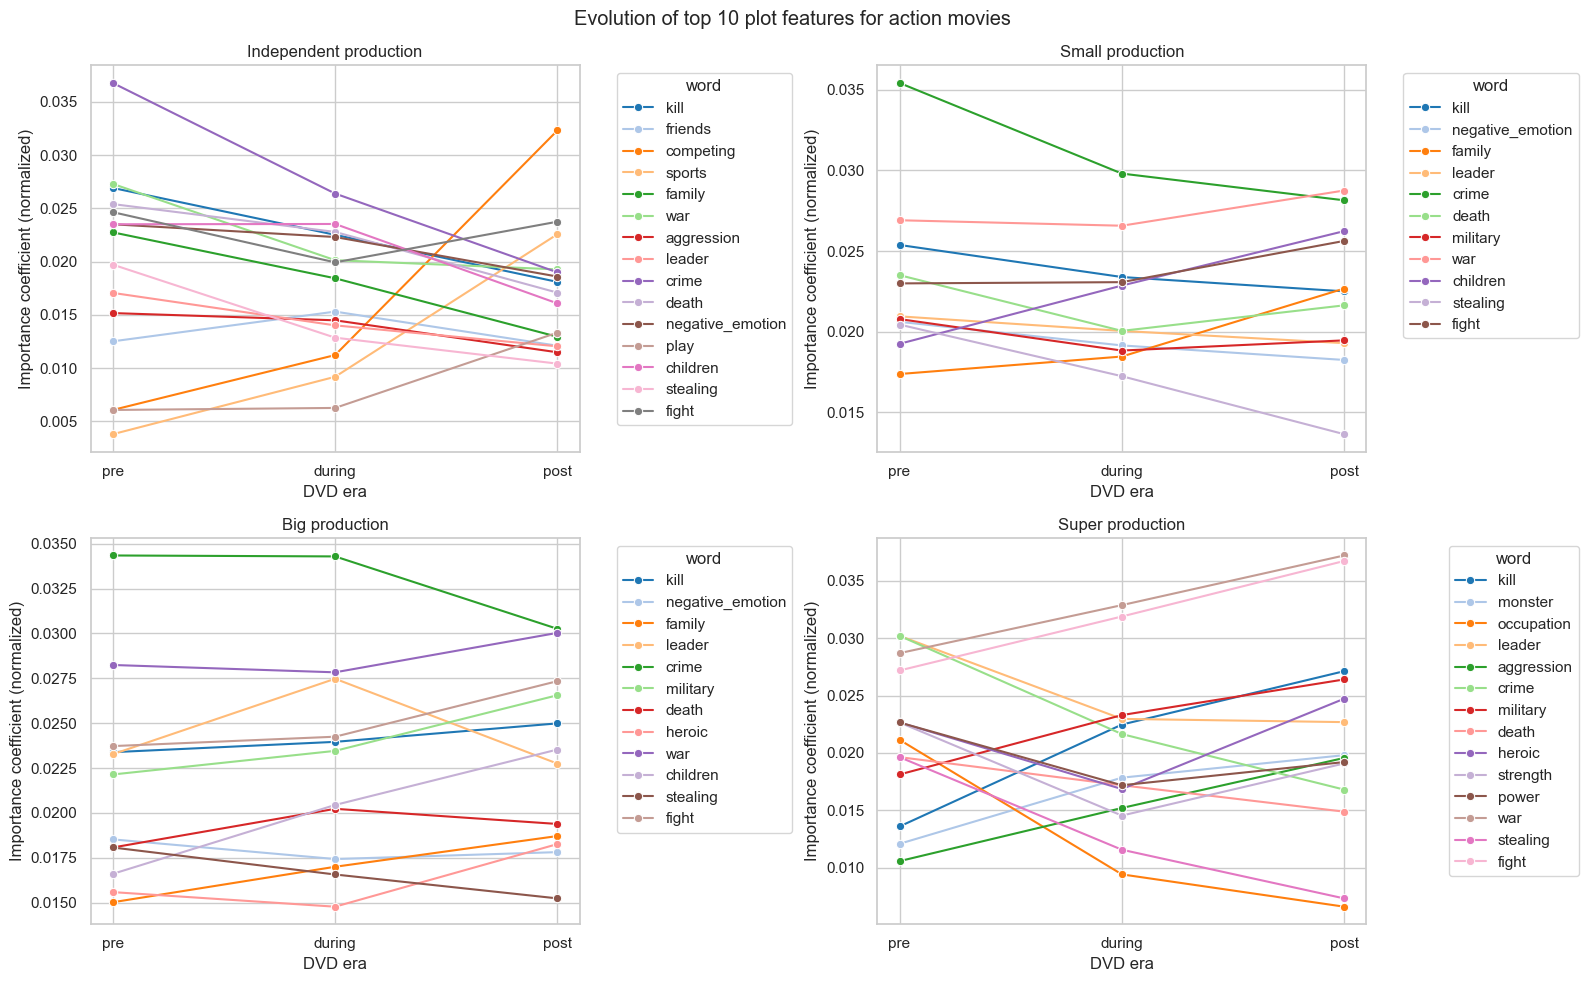

In [33]:
# Plot all features for the 'action' genre to visualize common themes across DVD eras.

empathModel.plot_all_features(results, 'action')

For action movies, Independent productions favored crime in the pre- and during DVD eras, but then display a large increase in competing and sports movies after the decline of DVDs. Small and Big productions also favored crime, with a slight decline after the onset of DVDs, with an increase in war in the post-DVD era. For Independent productions, while war, fight, crime and leader themes were initially equally common in the pre-DVD era, crime and leader show a steady decline while war and fight show a steady incline at the onset of DVDs. 

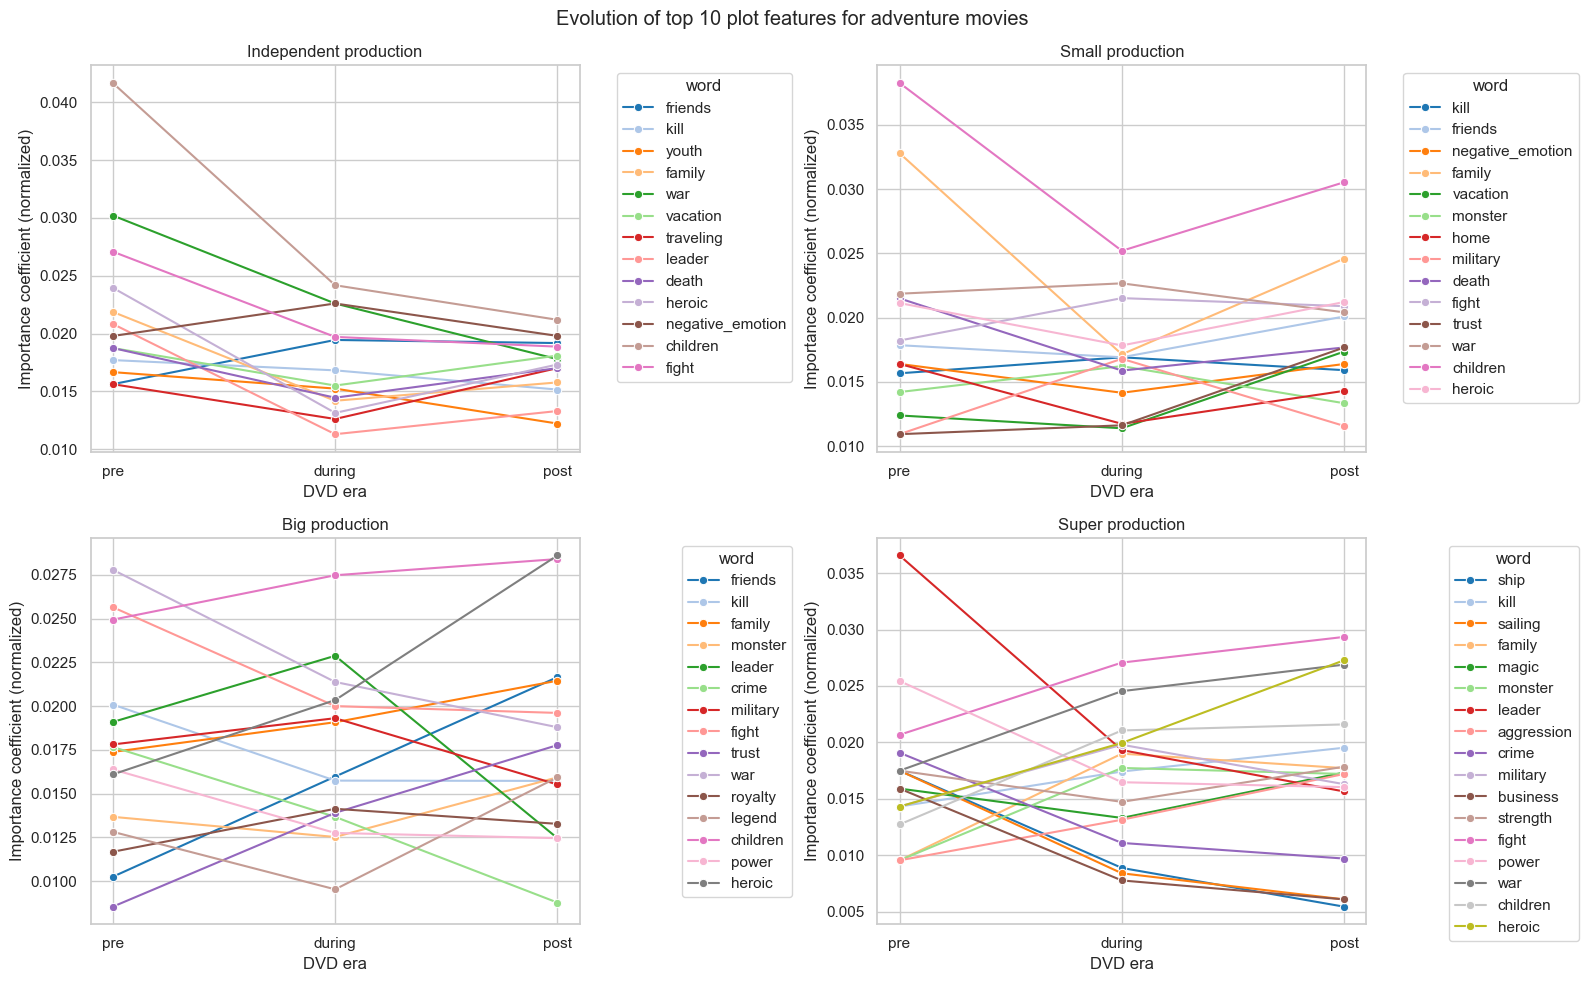

In [34]:
# Plot all features for the 'adventure' genre to visualize common themes across DVD eras.

empathModel.plot_all_features(results, 'adventure')

For adventure movies, we observe that the most common themes become increasingly "serious" with higher budgets. Indeed, while independent productions include themes like friends, vacation, and traveling, super productions replace them with themes such as military, aggression, or monster.  
Independent, Small and Big productions appear to continuously prioritize the children theme, even with decreasing popularity for independent and small productions after the onset of DVDs. Super production movies in the pre-DVD era seem to be centered are leader and power themes, only to be replaced with fight, war, and heroic themes in the peak and post DVD eras. 

 # Production countries
 

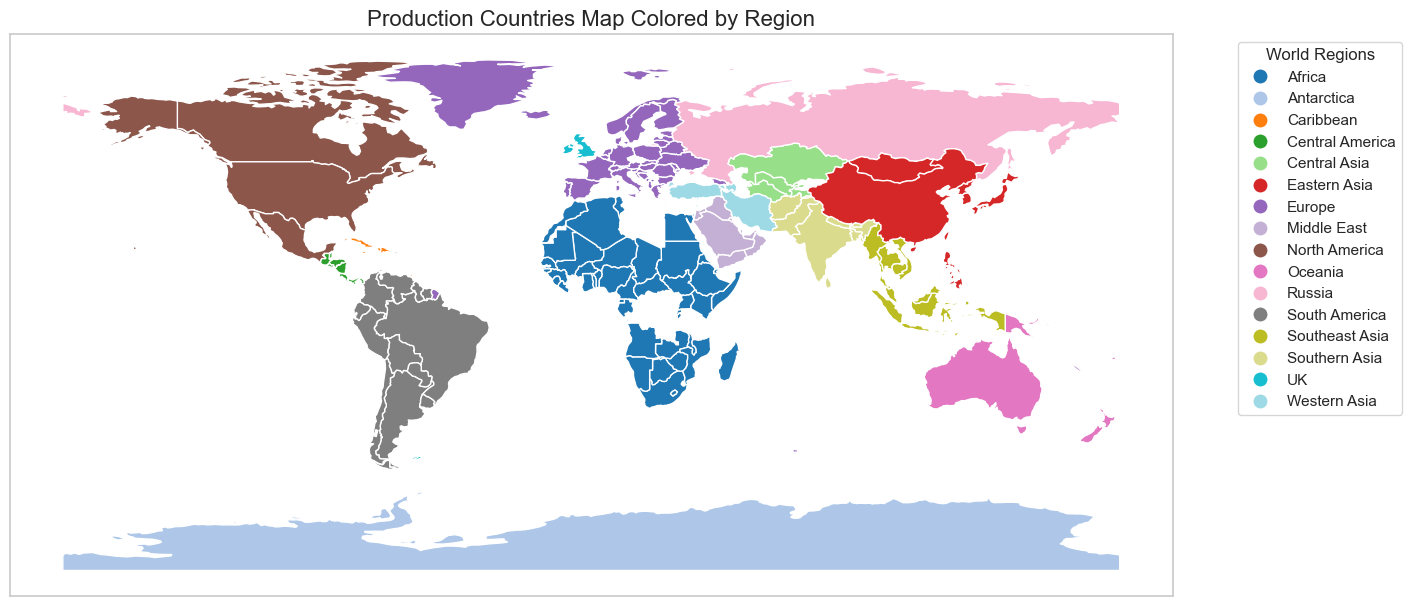

In [35]:
# Plot the world map with production countries colored by region.
with open('./data/countries_to_region.json', 'r') as file:
    countries_regions = json.loads(file.read())
    
plot_world_map(countries_regions)

In [36]:
# Create a DataFrame from the original DataFrame that contains exploded production countries and genres columns.
# Map production countries to regions using the 'countries_regions' dictionary and filter out any entries without a corresponding region.

df_countries = df.copy().explode('production_countries')
df_countries = df_countries.explode('genres')
df_countries['region'] = df_countries.production_countries.apply(lambda x: countries_regions[x] if x in countries_regions and pd.notna(x) else None)
df_countries.dropna(subset=['region'], inplace=True)

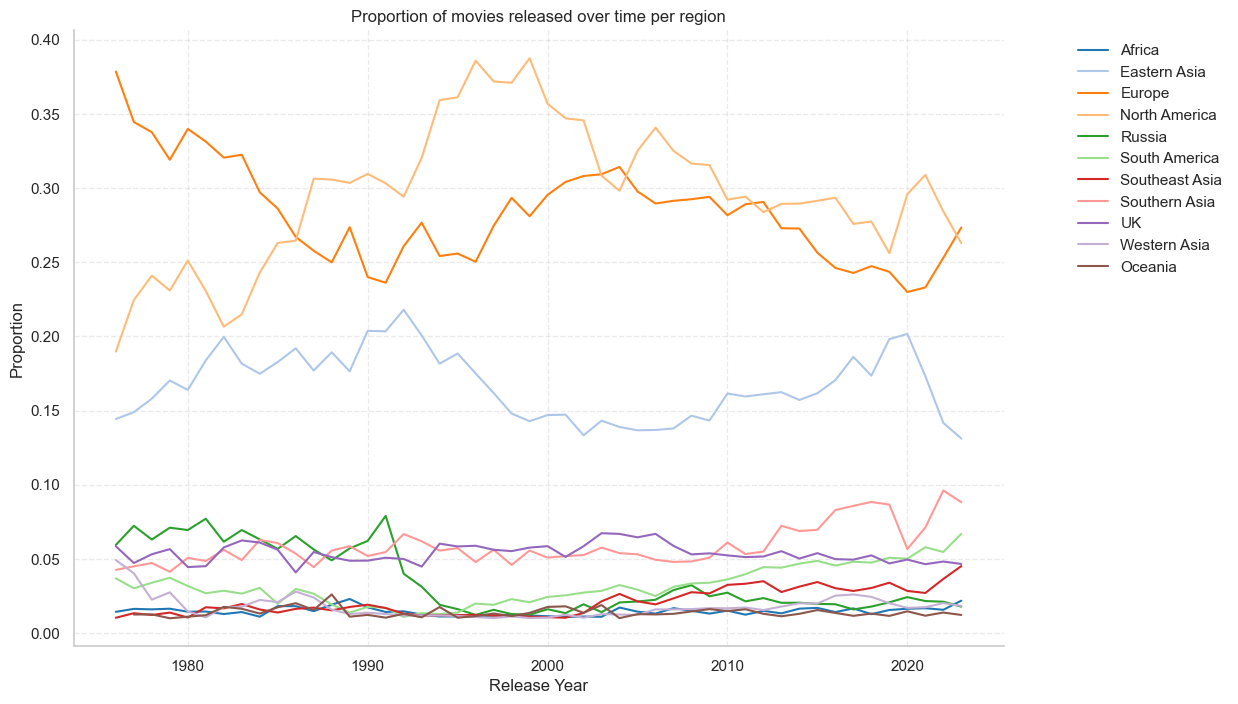

In [40]:
# Calculate the proportion of movies per region per year using the 'get_proportions' function.
# This function groups the data by 'release_year' and calculates the proportion of movies in each region.

region_props = get_proportions(df_countries, ['release_year'], 'region')
plot_movies_prop_per_region(region_props)

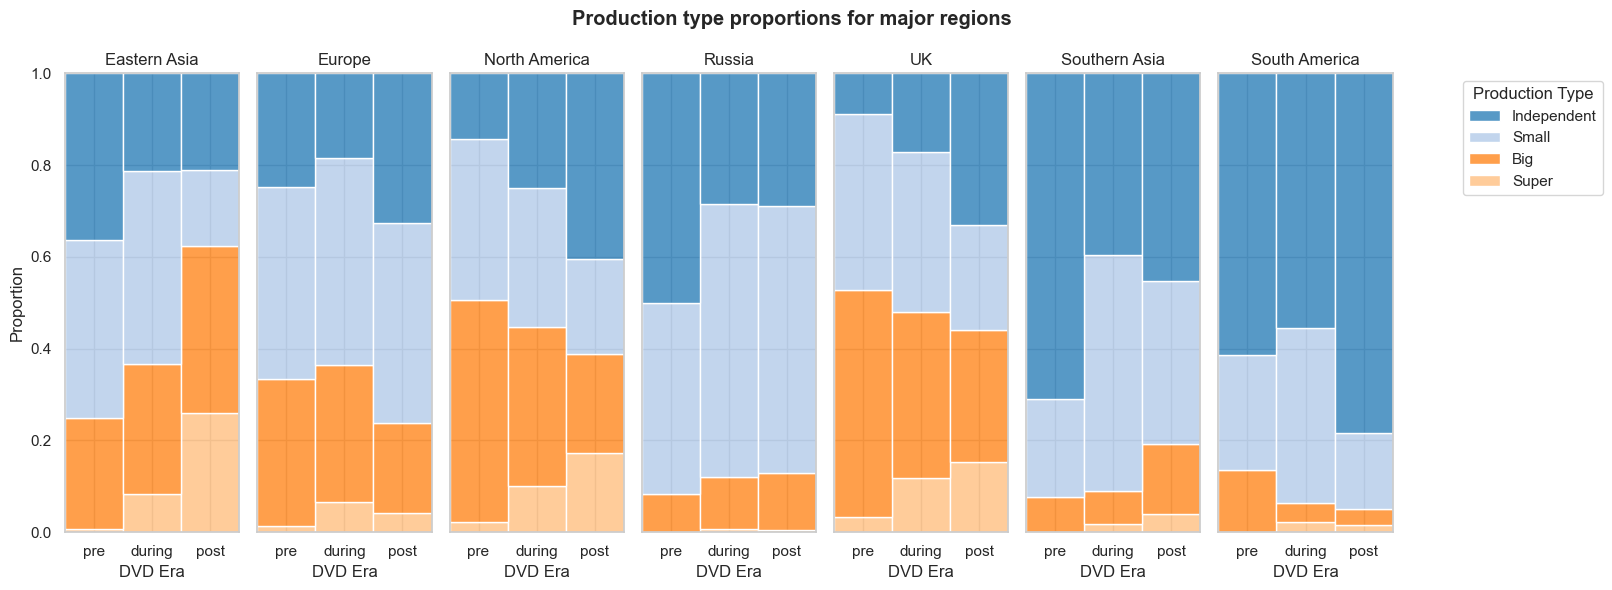

In [41]:
# Filtering the dataset to include only selected regions with a proportion greater than 0.05 and budgets greater than 0.
# Then, plotting the proportion of production types per region.

selected_regions = list(region_props[region_props.prop > 0.05].region.unique())
df_countries_filtered = df_countries[(df_countries.region.isin(selected_regions))
                                     & (df_countries.budget > 0)]

plot_prod_type_prop_per_region(selected_regions, df_countries_filtered)

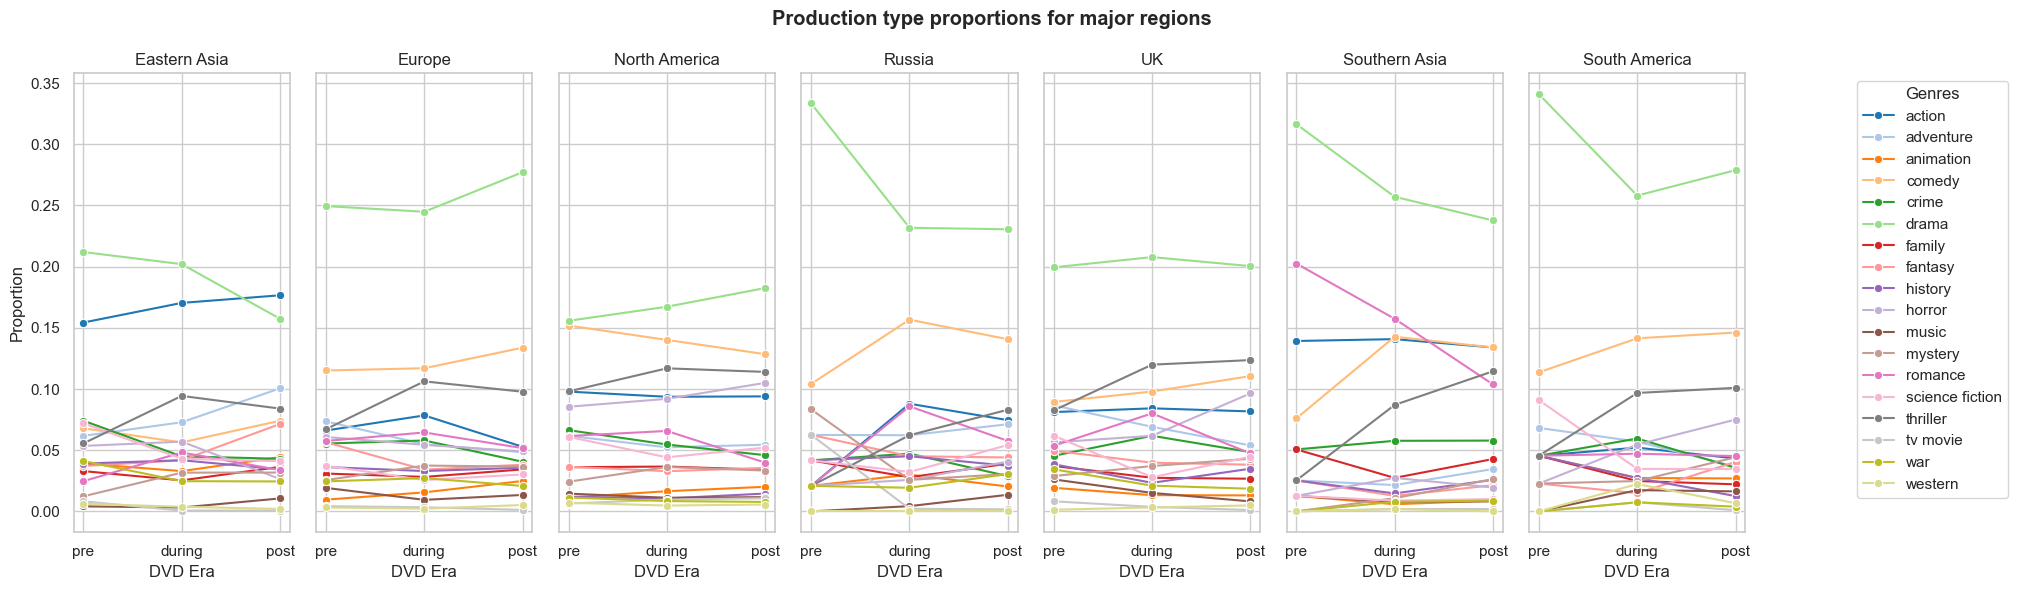

In [42]:
# Getting the proportions of genres per region across different DVD eras.
# Then, plotting these proportions for the selected regions.

countries_genres_props = get_proportions(df_countries_filtered, ['dvd_era', 'region'], 'genres')
plot_genre_prop_per_region(selected_regions, countries_genres_props)